In [1]:
import os
import sys
import gc
# assuming data, models, engine in flicc directory:
flicc_path = os.path.realpath("__file__").split('grid_search')[0]
sys.path.append(flicc_path)
import torch
from data import ClimateDataset
from models import ClassificationModel
from engine import Engine

In [2]:
model_checkpoint='facebook/opt-350m'

In [3]:
results = {'test_acc':[],
           'test_f1':[],
           'eval_acc':[],
           'eval_f1':[],
           'wd':[]}

In [4]:
g = 2
lr = 1.0e-5
weight_decay = [0.1, 0.01]

for wd in weight_decay:
    print(f'Grid search {model_checkpoint}, learning rate {lr}, focal loss gamma {g}, weight decay {wd}')
    data = ClimateDataset(model_to_train=2,model_checkpoint=model_checkpoint,dataset_url=flicc_path,batch_size=16)
    data.setup_dataloaders()
    model = ClassificationModel(model_checkpoint=data.model_checkpoint,num_labels=data.num_labels)
    trainer = Engine(epochs=30,labels=data.labels)
    trainer.model = model.model
    trainer.dataset_encoded = data.dataset_encoded
    test_acc, test_f1, eval_acc, eval_f1 = trainer.run(lr=lr,
                                                       wd=wd,
                                                       train_dataloader=data.train_dataloader,
                                                       eval_dataloader=data.eval_dataloader,
                                                       test_dataloader=data.test_dataloader,
                                                       focalloss=True,
                                                       accumulation_steps=2,
                                                       gamma=g,
                                                       early_stop=3)
    results['test_acc'].append(test_acc)
    results['test_f1'].append(test_f1)
    results['eval_acc'].append(eval_acc)
    results['eval_f1'].append(eval_f1)
    results['wd'].append(wd)
    print('### '*10)
    print(results)
    print('### '*10)
    with torch.no_grad():
        torch.cuda.empty_cache()
    del data, model, trainer, test_acc, test_f1, eval_acc, eval_f1
    gc.collect()

Grid search facebook/opt-350m, learning rate 1e-05, focal loss gamma 2, weight decay 0.1


Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-350m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


1 / 30: Train Loss:	3.2564	Val Loss:	1.2199	Accuracy:	0.4118	F1:	0.3560
2 / 30: Train Loss:	1.0501	Val Loss:	0.8944	Accuracy:	0.6471	F1:	0.6305
3 / 30: Train Loss:	0.6484	Val Loss:	0.8582	Accuracy:	0.6218	F1:	0.6232
4 / 30: Train Loss:	0.6364	Val Loss:	0.8411	Accuracy:	0.5378	F1:	0.5138
5 / 30: Train Loss:	0.6672	Val Loss:	0.7576	Accuracy:	0.6555	F1:	0.6452
6 / 30: Train Loss:	0.6692	Val Loss:	0.7913	Accuracy:	0.6303	F1:	0.6136
7 / 30: Train Loss:	0.6404	Val Loss:	0.9758	Accuracy:	0.4790	F1:	0.4356
8 / 30: Train Loss:	0.5975	Val Loss:	0.9157	Accuracy:	0.6134	F1:	0.6163
No improvement for 3 epochs. Stopping early.
best (higgest macro f1-score) val results:
                    precision    recall  f1-score   support

 misrepresentation       0.74      0.45      0.56        38
oversimplification       0.56      0.81      0.66        36
slothful induction       0.73      0.71      0.72        45

          accuracy                           0.66       119
         macro avg       0.67     

Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-350m and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


1 / 30: Train Loss:	3.2543	Val Loss:	1.2025	Accuracy:	0.4034	F1:	0.3429
2 / 30: Train Loss:	1.0374	Val Loss:	0.8958	Accuracy:	0.6471	F1:	0.6110
3 / 30: Train Loss:	0.6763	Val Loss:	0.8577	Accuracy:	0.6050	F1:	0.6081
4 / 30: Train Loss:	0.6188	Val Loss:	0.8384	Accuracy:	0.5798	F1:	0.5595
5 / 30: Train Loss:	0.6421	Val Loss:	0.7515	Accuracy:	0.6807	F1:	0.6826
6 / 30: Train Loss:	0.6523	Val Loss:	0.7726	Accuracy:	0.6303	F1:	0.6201
7 / 30: Train Loss:	0.6459	Val Loss:	0.9077	Accuracy:	0.4790	F1:	0.4502
8 / 30: Train Loss:	0.6443	Val Loss:	1.2572	Accuracy:	0.4790	F1:	0.4472
No improvement for 3 epochs. Stopping early.
best (higgest macro f1-score) val results:
                    precision    recall  f1-score   support

 misrepresentation       0.57      0.74      0.64        38
oversimplification       0.66      0.75      0.70        36
slothful induction       0.90      0.58      0.70        45

          accuracy                           0.68       119
         macro avg       0.71     

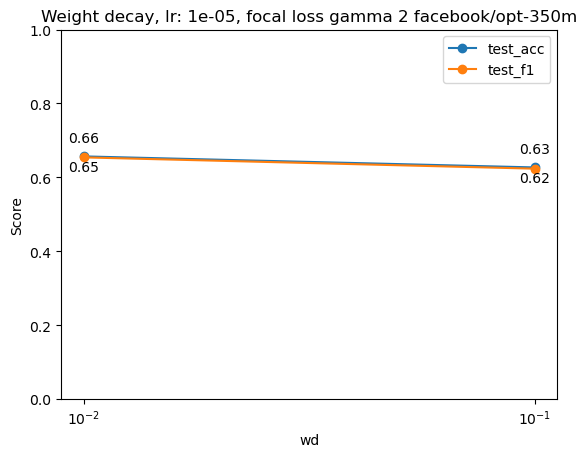

In [5]:
Engine.plot_grid_search(df=results,
                        title=f'Weight decay, lr: {lr}, focal loss gamma {g} {model_checkpoint}',
                        column='wd',
                        sci_format=True)

In [6]:
%reset -f